## Matching Scales

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd
import math
import cmath

import pywt # PyWavelets

In [84]:
# NCL Output
sst_data = np.loadtxt("data/nino3sst_trimmed.txt")
time_0 = 1871.0
dt = 0.25  # years (4 per year, seasonal)

ncl_data = np.genfromtxt("data/ncl_csv.csv", skip_header=1, delimiter=',')
ncl_data = ncl_data[:,1]
time_range = (np.arange(0, len(ncl_data)) * dt) + time_0 # from 1871.00 to 1996.75
ncl_df = pd.DataFrame({'time (years)': time_range, 'temperature (C)': ncl_data})
ncl_df.head()

,time (years),temperature (C)
0,1871.00,-0.15
1,1871.25,-0.30
2,1871.50,-0.14
3,1871.75,-0.41
4,1872.00,-0.46


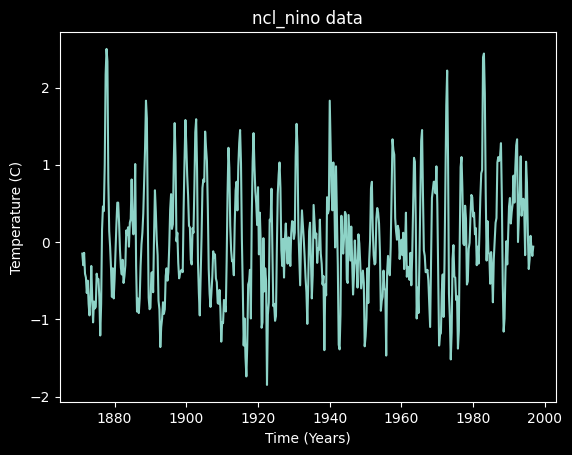

In [85]:
plt.style.use('dark_background')
fig, ax = plt.subplots()
fig = plt.plot(ncl_df["time (years)"], ncl_df["temperature (C)"])
plt.title("ncl_nino data")
plt.xlabel("Time (Years)")
plt.ylabel("Temperature (C)")
plt.show()

In [71]:
# PyWavelets complex morlet
# https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#wavelet-bandwidth-and-center-frequencies

wavelets (4): 
['cmor1.0-0.5', 'cmor1.0-0.8', 'cmor1.0-1.0', 'cmor1.0-1.2']


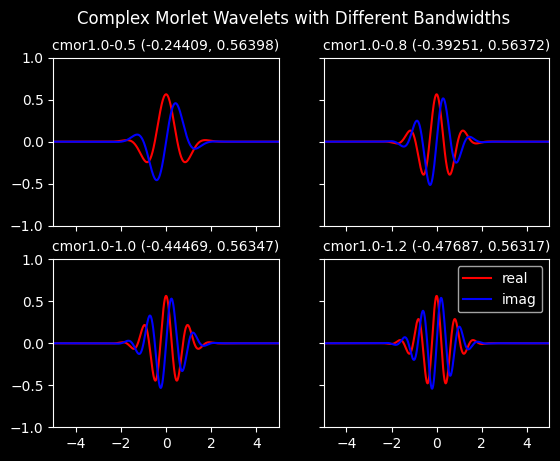

In [86]:
# plot complex morlet wavelets with different center frequencies and bandwidths
y_range = np.arange(0.5, 1.5, 0.25)
wavelets = [f"cmor1.0-{y:.1f}" for y in y_range]
print(f"wavelets ({len(wavelets)}): \n{wavelets}")
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
for ax, wavelet in zip(axs.flatten(), wavelets):
    [psi, x] = pywt.ContinuousWavelet(wavelet).wavefun(10)
    ax.plot(x, np.real(psi), label="real", c="red")
    ax.plot(x, np.imag(psi), label="imag", c="blue")
    ax.set_title(f"{wavelet} ({np.min(np.real(psi)):.5f}, {np.max(np.real(psi)):.5f})", fontsize=10)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-1, 1])
ax.legend()
plt.suptitle("Complex Morlet Wavelets with Different Bandwidths")
plt.show()

wavelets (4): 
['cmor1.0-1.0', 'cmor1.5-1.0', 'cmor2.0-1.0', 'cmor2.5-1.0']


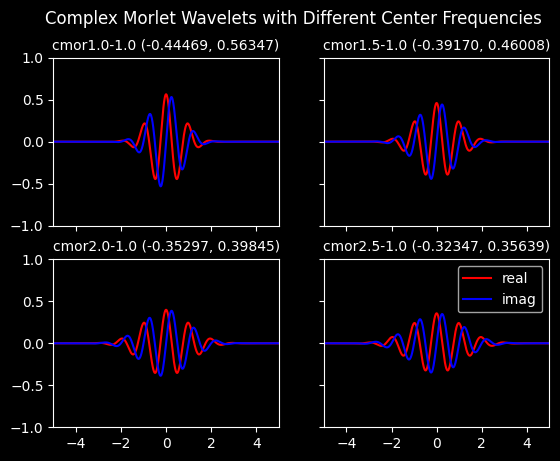

In [87]:
# plot complex morlet wavelets with different center frequencies
x_range = np.arange(1.0, 3, 0.5)#[0.5, 1.5, 2.5]
wavelets = [f"cmor{x:.1f}-1.0" for x in x_range]
print(f"wavelets ({len(wavelets)}): \n{wavelets}")
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
for ax, wavelet in zip(axs.flatten(), wavelets):
    [psi, x] = pywt.ContinuousWavelet(wavelet).wavefun(10)
    ax.plot(x, np.real(psi), label="real", c="red")
    ax.plot(x, np.imag(psi), label="imag", c="blue")
    ax.set_title(f"{wavelet} ({np.min(np.real(psi)):.5f}, {np.max(np.real(psi)):.5f})", fontsize=10)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-1, 1])
ax.legend()
plt.suptitle("Complex Morlet Wavelets with Different Center Frequencies")
plt.show()

wavelets (16) (4, 4): 
['cmor1.0-0.5', 'cmor1.0-0.8', 'cmor1.0-1.0', 'cmor1.0-1.2', 'cmor1.5-0.5', 'cmor1.5-0.8', 'cmor1.5-1.0', 'cmor1.5-1.2', 'cmor2.0-0.5', 'cmor2.0-0.8', 'cmor2.0-1.0', 'cmor2.0-1.2', 'cmor2.5-0.5', 'cmor2.5-0.8', 'cmor2.5-1.0', 'cmor2.5-1.2']


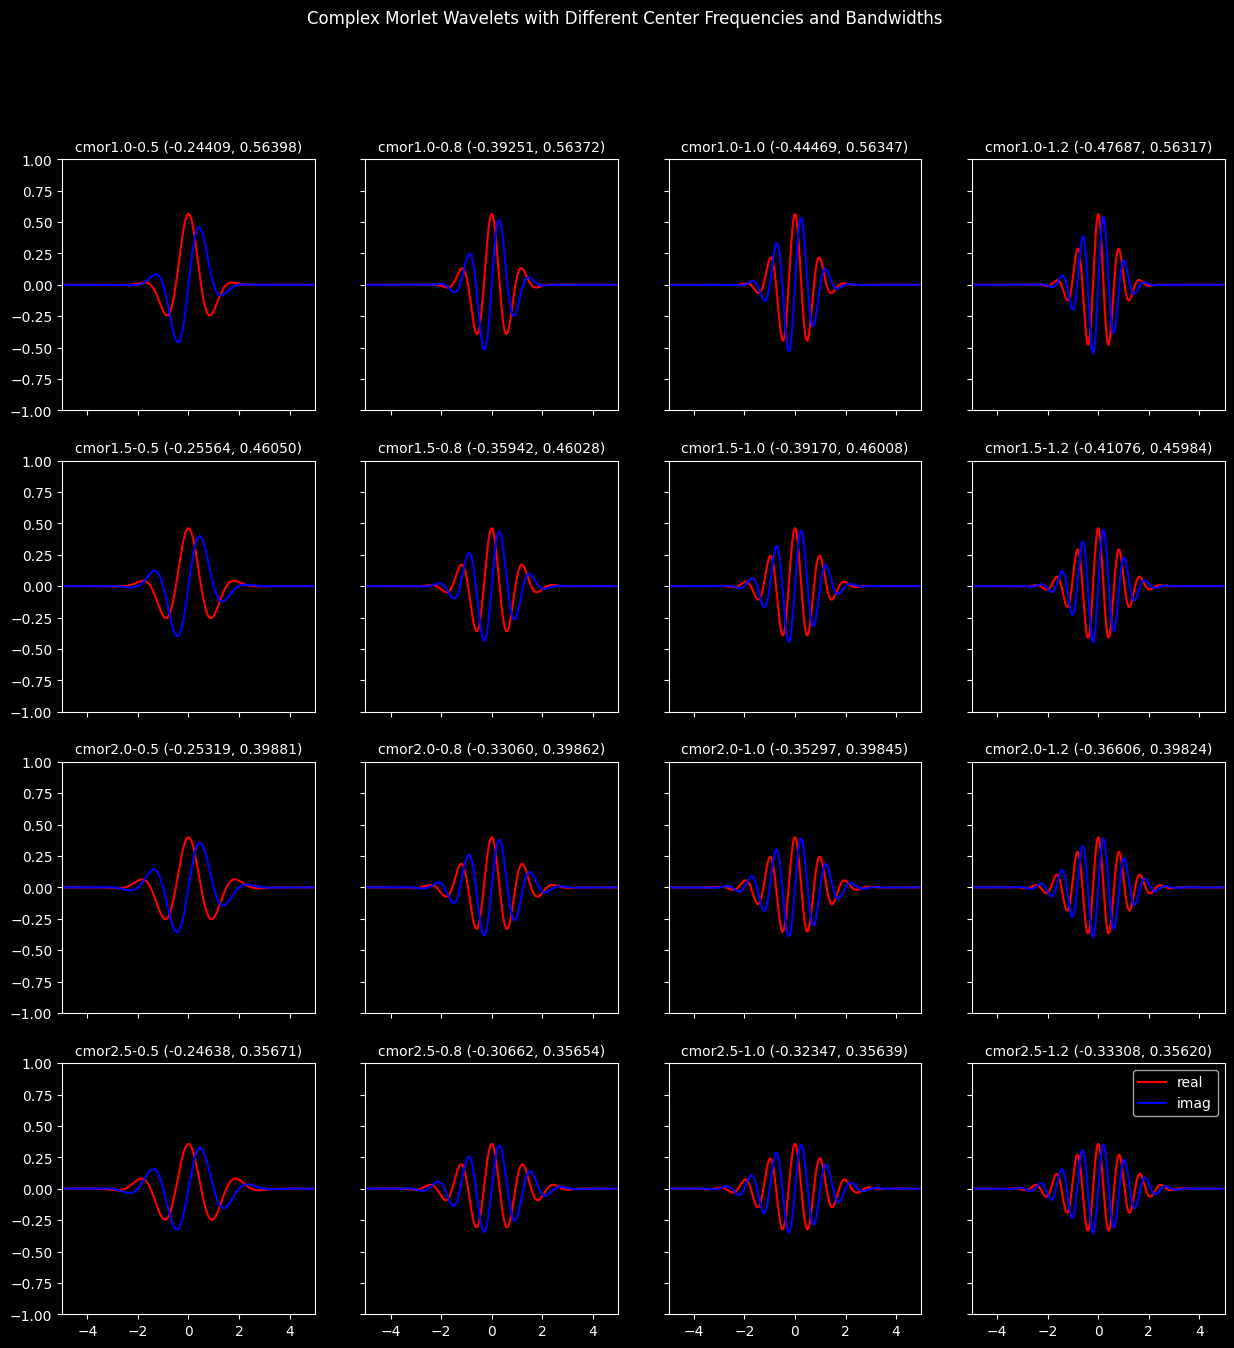

In [88]:
# plot complex morlet wavelets with different center frequencies and bandwidths
x_range = np.arange(1.0, 3.0, 0.5)#[0.5, 1.5, 2.5]
y_range = np.arange(0.5, 1.5, 0.25)#[0.5, 1.0, 1.5]
wavelets = [f"cmor{x:.1f}-{y:.1f}" for x in x_range for y in y_range]
sub_plot_x = int(math.sqrt(len(wavelets)))
sub_plot_y = len(wavelets) - sub_plot_x**2
if sub_plot_y == 0: sub_plot_y = sub_plot_x
print(f"wavelets ({len(wavelets)}) ({sub_plot_x}, {sub_plot_y}): \n{wavelets}")
fig, axs = plt.subplots(sub_plot_x, sub_plot_y, figsize=(15, 15), sharex=True, sharey=True)
for ax, wavelet in zip(axs.flatten(), wavelets):
    [psi, x] = pywt.ContinuousWavelet(wavelet).wavefun(10)
    ax.plot(x, np.real(psi), label="real", c="red")
    ax.plot(x, np.imag(psi), label="imag", c="blue")
    ax.set_title(f"{wavelet} ({np.min(np.real(psi)):.5f}, {np.max(np.real(psi)):.5f})", fontsize=10)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-1, 1])
ax.legend()
plt.suptitle("Complex Morlet Wavelets with Different Center Frequencies and Bandwidths")
plt.show()

In [89]:
def complex_morlet_pywavelets(time_step, B, C):
    # https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#complex-morlet-wavelets
    part1 = 1/np.sqrt(math.pi*B)
    part2 = math.exp(-np.power(time_step, 2)/B)
    part3 = cmath.exp(1j * 2 * math.pi * C * time_step)
    return part1 * part2 * part3

def morlet_pywavelets(time_step):
    # https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#morlet-wavelet
    # 'morl'
    part1 = math.exp(-np.power(time_step, 2)/2)
    part2 = math.cos(5*time_step)
    return part1*part2

def tc_morlet(time_step):
    # Table 1: https://psl.noaa.gov/people/gilbert.p.compo/Torrence_compo1998.pdf
    i = np.sqrt(-1+0j) # complex i
    omega = 6 # w, nondimensional frequency, defaults to 6 (~2pi)
    eta = time_step # n, wavelet function nondimensional "time" parameter
    part1 = np.power(math.pi, -1/4)
    part2 = cmath.exp(i*omega*eta)
    part3 = math.exp(-np.power(eta, 2)/2)
    return part1 * part2 * part3

In [115]:
# Verify Equations 

# Integrate to ~0
from scipy.integrate import quad
bandwidth = math.sqrt(math.pi)
center_freq = 6/(2*math.pi) # C * 2 * pi = 1 * 2 * pi = approx 6 (morlet default)

integrate_range = 100000
cmor_integration = quad(complex_morlet_pywavelets, -integrate_range, integrate_range, args=(bandwidth,center_freq))
tc_integration = quad(tc_morlet, -integrate_range, integrate_range)
print("Verify Integration of Equation == 0")
print(f"cmor_integration {cmor_integration} == (0.0, 0.0) = {cmor_integration == (0.0, 0.0)}")
print(f"tc_integration   {tc_integration} == (0.0, 0.0) = {tc_integration == (0.0, 0.0)}")

Verify Integration of Equation == 0
cmor_integration (0.0, 0.0) == (0.0, 0.0) = True
tc_integration   (0.0, 0.0) == (0.0, 0.0) = True


In [100]:
# cmorB-C
# https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#complex-morlet-wavelets
# B = bandwidth
# C = center frequency
bandwidth = math.sqrt(math.pi)
center_freq = 6/(2*math.pi) # C * 2 * pi = 1 * 2 * pi = approx 6 (morlet default)

complex_morlet = f"cmor{bandwidth}-{center_freq}"
[psi, x] = pywt.ContinuousWavelet(complex_morlet).wavefun(10)
[psi_m, x_m] = pywt.ContinuousWavelet('morl').wavefun(10)

tc_output = []
mor_pywt_output = []
cmor_pywt_output = []
for x_value in x:
    tc_output.append(tc_morlet(x_value))
    mor_pywt_output.append(morlet_pywavelets(x_value))
    cmor_pywt_output.append(complex_morlet_pywavelets(x_value, bandwidth, center_freq))

In [101]:
print(f"range tc morlet output (equation)          = ({np.min(np.real(tc_output))}, {np.max(np.real(tc_output))})")
print(f"range cmor morlet pywavelets output        = ({np.min(np.real(cmor_pywt_output))}, {np.max(np.real(cmor_pywt_output))})")
print(f"range complex morlet pywavelets (equation) = ({np.min(np.real(psi))}, {np.max(np.real(psi))})")

range tc morlet output (equation)          = (-0.6573192867703035, 0.7502759291315703)
range cmor morlet pywavelets output        = (-0.3647527629921258, 0.42329620235671245)
range complex morlet pywavelets (equation) = (-0.3647527581759707, 0.42329619600753465)


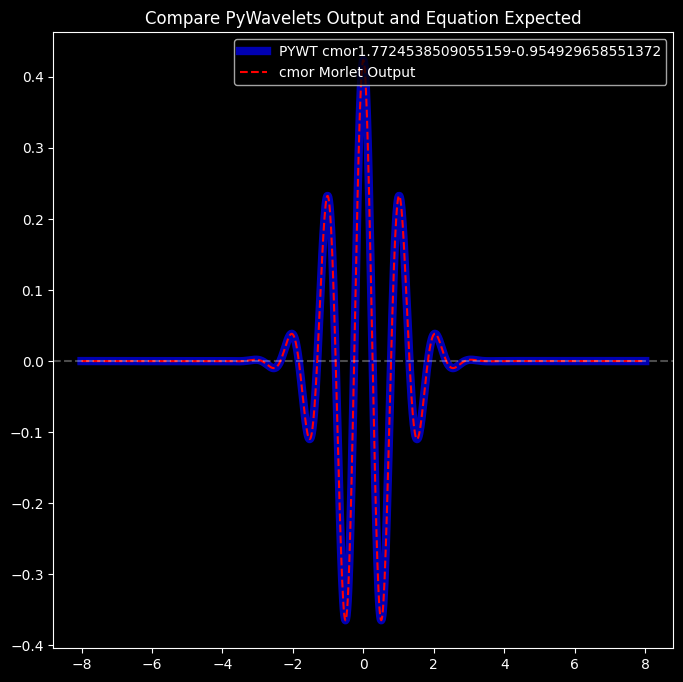

In [118]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(x, np.real(psi), label=f"PYWT {complex_morlet}", c="blue", linewidth=6, alpha=0.7)
ax.plot(x, np.real(cmor_pywt_output), label="cmor Morlet Output", linestyle='--', c="red")
plt.title("Compare PyWavelets Output and Equation Expected")
ax.axhline(0, linestyle='--', alpha=0.3)
ax.legend()
plt.show()

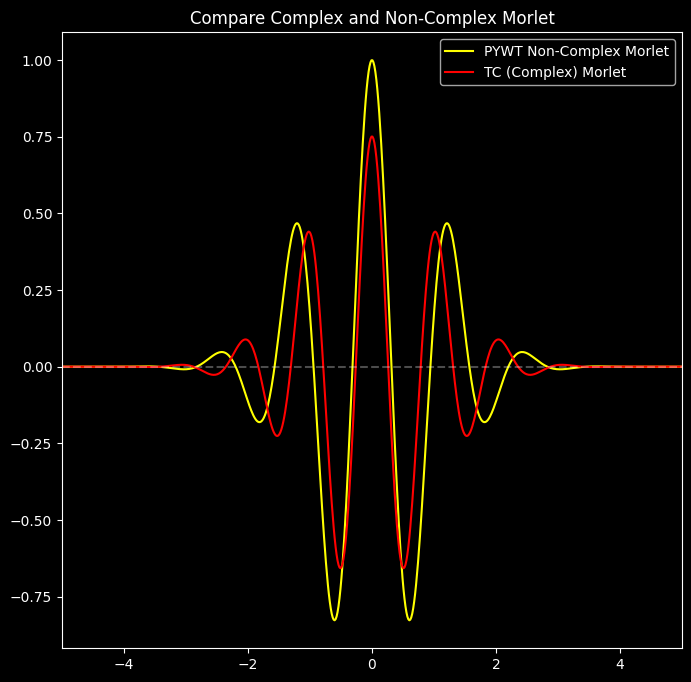

In [93]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(x, np.real(psi_m), label="PYWT Non-Complex Morlet", c="yellow")
ax.plot(x, np.real(tc_output), label="TC (Complex) Morlet", c="red")
plt.title("Compare Complex and Non-Complex Morlet")
ax.axhline(0, linestyle='--', alpha=0.3)
ax.set_xlim([-5, 5])
ax.legend()
plt.show()

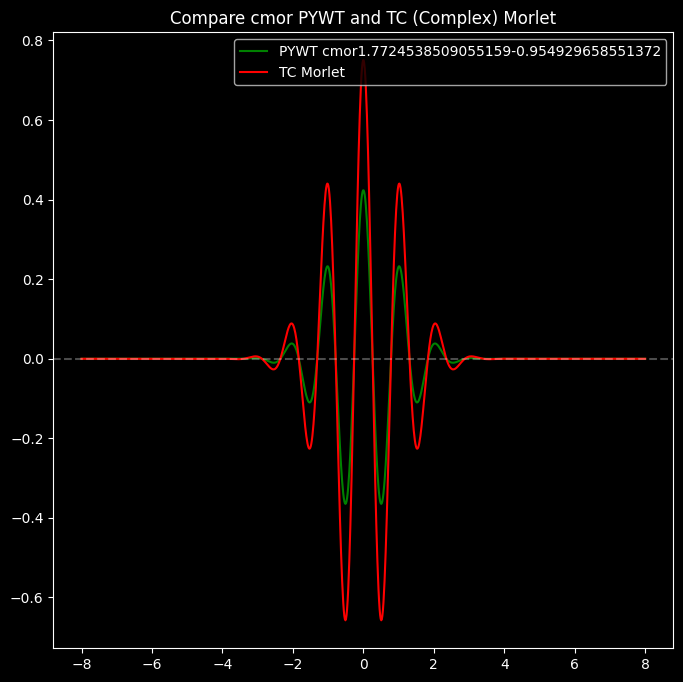

In [119]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(x, np.real(psi), label=f"PYWT cmor", c="green")
ax.plot(x, np.real(tc_output), label="TC Morlet", c="red")
plt.title(f"Compare cmor PYWT {complex_morlet} and TC (Complex) Morlet")
ax.axhline(0, linestyle='--', alpha=0.3)
ax.legend()
plt.show()